In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

## Any results you write to the current directory are saved as output.

['jigsaw-toxic-comment-classification-challenge', 'fasttext2']


In [2]:
#importing standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Importing Keras so that I can apply CNN
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

#importing libraries for data processing
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)
#Setting path for kaggle data.
DATA_PATH = '../input/'
EMBEDDING_DIR = '../input/'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#load embeddings
embeddings_index = {}
#Have downloaded fastext pretrained embeddings. So loading it here
f = codecs.open('../input/fasttext2/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

111052it [00:14, 7899.99it/s]


In [4]:
#load data traning and test dataset
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge' + '/train.csv', sep=',', header=0)
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge' + '/test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training examples: ", train_df.shape[0])
print("Number of test examples: ", test_df.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_names].values

Number of training examples:  159571
Number of test examples:  153164


In [5]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist() 
num_classes = len(label_names)

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))


100%|██████████| 153164/153164 [00:04<00:00, 35468.01it/s]


In [6]:
#Tokenizing data.

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

#So here we are padding the sequnce so that I will work ML algorithms because
#it should have same length
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

dictionary size:  348520


In [7]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [8]:
#embedding matrix
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 47196


In [9]:
print("Words not found in the embedding: ", np.random.choice(words_not_found, 20))

Words not found in the embedding:  ['bunchofgrapes' 'hapy' 'kwilu' 'weant' 'sthenelaos' 'everyon' 'mcsim'
 'kodachrome' 'latibeaudiere' 'thấp' 'yhcu3r' 'exclusiveness'
 'improvments' 'صغير' 'maybes' 'parsedouble' 'techinc' 'doget' 'gossips'
 'hornplease']


In [10]:
#CNN model training
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
__________

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [12]:
#sending the data to CNN to train the model
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/8
 - 475s - loss: 0.0975 - acc: 0.9702 - val_loss: 0.0676 - val_acc: 0.9778
Epoch 2/8
 - 472s - loss: 0.0656 - acc: 0.9787 - val_loss: 0.0626 - val_acc: 0.9791
Epoch 3/8
 - 475s - loss: 0.0583 - acc: 0.9803 - val_loss: 0.0590 - val_acc: 0.9795
Epoch 4/8
 - 475s - loss: 0.0527 - acc: 0.9818 - val_loss: 0.0590 - val_acc: 0.9792
Epoch 5/8
 - 474s - loss: 0.0481 - acc: 0.9829 - val_loss: 0.0593 - val_acc: 0.9802
Epoch 00005: early stopping


In [13]:
y_test = model.predict(word_seq_test)

In [ ]:
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv('../input' +'/fasttext2' +'/cnn_fasttext_submission.csv', index=False)

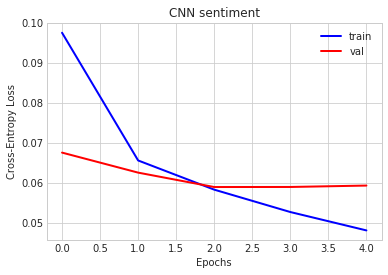

In [17]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

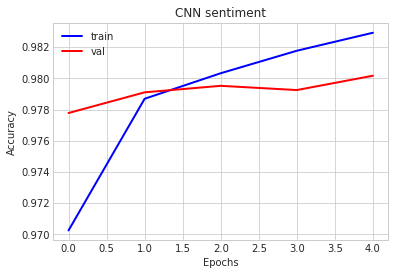

In [18]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()